# Guided Motif Discovery with Annotation Vectors

This tutorial summarizes the findings of the [Matrix Profile V](https://www.cs.ucr.edu/~eamonn/guided-motif-KDD17-new-format-10-pages-v005.pdf) paper and replicates the presented case studies.

In the [Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) paper and the [STUMPY Basics](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) tutorial we have explored the discovery of time series motifs using the matrix profile. While the concept of motif discovery is crucial to many fields and practical applications, the process of motif discovery isn't usually as clean in the real world as we would like it to be. In most practical uses of motif discovery, we find some motifs to be more desirable than others.

Consider, for instance, the [Amazon Customer Reviews Dataset](https://www.kaggle.com/bittlingmayer/amazonreviews) which contains several million customer reviews from Amazon's website. If we were to combine all the textual reviews to reveal the most used words on the platform, we would, unsurprisingly, find the word "Amazon" to be around the top of the list, probably following a few other more commonly used words, such as "the", "and" and "is". While this result is obvious, it is certainly not useful. In order to produce more insightful results, we would need to filter this dataset to exclude less interesting, or "[stop words](https://en.wikipedia.org/wiki/Stop_word)", and make way for the more interesting ones.

When it comes to motif discovery, we use a similar approach. While we can't "filter" a time series, we can incentivize the identification of more interesting motifs and penalize that of the less interesting ones. This tutorial will cover the process of **Guided Motif Search** and **Annotation Vectors** in the context of tackling the following motif biases:

1. Actionability Bias
2. Stop-Word Motif Bias
3. Simplicity Bias

## Getting Started

Let’s import the packages that we’ll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from stumpy import stump
from stumpy.core import mass

plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams['xtick.direction'] = 'out'

## What are Annotation Vectors

An annotation vector is a time series that highlights the "importance" of subsequences of another time series. It is usually a vector of real-valued numbers between 0 and 1, with 0 indicating an undesirable motif and 1 indicating a desirable one.

Consider the [Dodgers Loop Sensor Dataset](https://archive.ics.uci.edu/ml/datasets/Dodgers+Loop+Sensor) contains traffic data from Glendale, Los Angeles.

In [2]:
dodgers_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.data', header=None)

dodgers_df.columns = ['DateTime', 'Count']
dodgers_df = dodgers_df[dodgers_df.Count != -1]

dodgers_df[['Date', 'Time']] = dodgers_df['DateTime'].str.split(' ', expand=True)
dodgers_df = dodgers_df.drop('DateTime', 1)

dodgers_df[['Hour', 'Minute']] = dodgers_df['Time'].str.split(':', expand=True)
dodgers_df = dodgers_df.drop('Time', 1)

dodgers_df[['Month', 'Day', 'Year']] = dodgers_df['Date'].str.split('/', expand=True)
dodgers_df = dodgers_df.drop('Date', 1)

dodgers_df = dodgers_df[['Minute', 'Hour', 'Day', 'Month', 'Year', 'Count']]
dodgers_df.head()

,Minute,Hour,Day,Month,Year,Count
379,35,7,11,4,2005,23
380,40,7,11,4,2005,42
381,45,7,11,4,2005,37
382,50,7,11,4,2005,24
383,55,7,11,4,2005,39


The dataset provides the number of cars detected at regular intervals throughout the day. We can certainly obtain the matrix profile of this time series and extract motifs.

But what if we only want motifs from the morning, and ignore the data from all other times? In cases like this, where we need to exclude or tone down certain parts of the time series, we build an annotation vector. We can consider morning time to be between 5 AM and 12 AM and construct an annotation vector that is 1 during the that time and 0 otherwise:

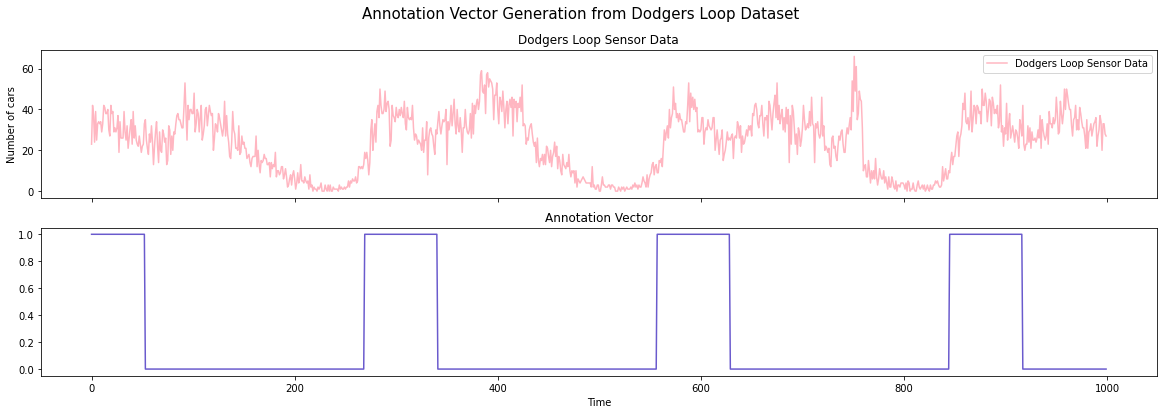

In [3]:
dodgers_count = np.array(dodgers_df['Count']).astype(np.uint16)
dodgers_hour = np.array(dodgers_df['Hour']).astype(np.uint8)

annotation_vector = (dodgers_hour > 5) & (dodgers_hour < 12).astype(np.uint8)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Annotation Vector Generation from Dodgers Loop Dataset', fontsize='15')

axis[0].plot(dodgers_count[:1000], color='lightpink', label='Dodgers Loop Sensor Data')
axis[0].legend()
axis[0].set_ylabel('Number of cars')
axis[0].set_title('Dodgers Loop Sensor Data')

axis[1].plot(annotation_vector[:1000], color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

We can then combine this annotation vector with the matrix profile to formulate a **Corrected Matrix Profile** which we can use to identify our desirable motifs. The corrected matrix profile can be acquired using the following formula:

$$
\begin{align*}
CMP[i] &= MP[i] + (1 - AV[i]) \times max(MP)
\end{align*}
$$

$CMP$ is the corrected matrix profile, $MP$ is the original matrix profile, $AV$ is the annotation vector and $max(MP)$ is the maximum value of the original matrix profile. We will demonstrate the use of this formula in the case studies below.

## Actionability Bias

**Actionability Bias** refers to the greater actionability or exploitability of certain data subsets than others. In other words, certain subsequences are more interesting than others. In the Dodgers Loop Sensor Dataset, we assigned more importance to the data collected during the morning, making that data more actionable and useful than the data from the rest of the day. The actionability patterns of subsequences of a dataset is certainly dependent on the context and are generally arbitrary.

### Suppressing Motion Artifact

In order to introduce actionability bias in our motif search, we can construct an annotation vector based on desirable and undesirable time series subsequences. In many cases, the undesirability of some subsquences is absolute. In other words, we want to completely disable some regions in the time series from being considered for our motif search. This was the case in the Dodgers Loop dataset example, where we only wanted to focus on the data between 5 AM and 12 AM, and so in that interval, the annotation vector was 1. In all other intervals, the annotation vector was 0. There was no in-between.

Consider the [fNIRS brain imaging dataset](https://drive.google.com/file/d/0B1ZwONZKxJgTa2lFdDMtTnZMTUU/view?usp=sharing) produced by the UCLA Medical Center. **fNIRS**, or **functional near-infrared specroscopy** is an optical imaging technique that is used to measure hemoglobin concentrations throughout the brain. We can download this directly from [Google Drive](https://drive.google.com/file/d/0B1ZwONZKxJgTa2lFdDMtTnZMTUU/view?usp=sharing), or use `gdown`.

In [4]:
!pip3 install gdown
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTa2lFdDMtTnZMTUU

You are using pip version 18.1, however version 21.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTa2lFdDMtTnZMTUU
To: C:\Users\zzaman\Documents\personal\STUMPY\AnnotationVectors\fNIRS_subLen_600.mat

  0%|          | 0.00/231k [00:00<?, ?B/s]
100%|##########| 231k/231k [00:00<00:00, 1.22MB/s]
100%|##########| 231k/231k [00:00<00:00, 1.22MB/s]


In [5]:
dataset = loadmat('fNIRS_subLen_600.mat')

fNIRS_data = dataset['data'][0]
acc_data = dataset['data'][1]

df = {
    'fNIRS Data': fNIRS_data,
    'Sensor Acceleration': acc_data,
}

df = pd.DataFrame(df)
df.head()

,fNIRS Data,Sensor Acceleration
0,4999,8105
1,4998,7959
2,4998,8057
3,5000,7959
4,5003,8008


The dataset contains two columns: the fNIRS data and the sensor acceleration data, the latter of which we will get to later. We can visualize the fNIRS data time series first. In order to simplify the demonstration, we will be working with a smaller subset of the dataset.

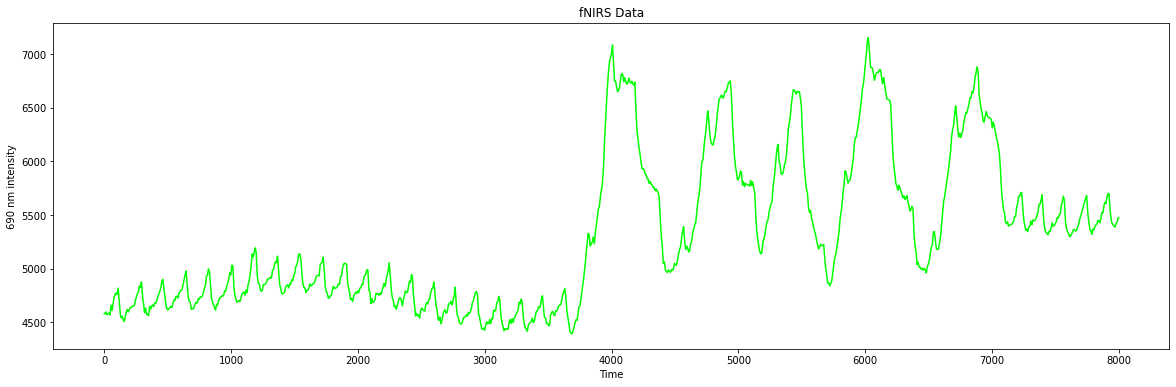

In [6]:
fNIRS_data = fNIRS_data[6000:14000].astype(np.float64)
acc_data = acc_data[6000:14000].astype(np.float64)

plt.plot(fNIRS_data, color='lime', label='fNIRS Data')
plt.xlabel('Time')
plt.ylabel('690 nm intensity')
plt.title('fNIRS Data')
plt.show()

The time series visualization already gives us an idea where the nearest neighbor pairs might be located. We can use the `stump` function from STUMPY to compute the matrix profile of this time series.

In [7]:
def getMotifData(data, matrix_profile, window_size):
    motif_index = np.argmin(matrix_profile[:, 0])
    motif_x = np.arange(motif_index, motif_index + window_size)
    motif_y = data[motif_index:motif_index + window_size]
    motif = (motif_index, motif_x, motif_y)

    neighbor_index = matrix_profile[motif_index, 1]
    neighbor_x = np.arange(neighbor_index, neighbor_index + window_size)
    neighbor_y = data[neighbor_index:neighbor_index + window_size]
    neighbor = (neighbor_index, neighbor_x, neighbor_y)
    
    return motif, neighbor

In [8]:
window_size = 600
matrix_profile = stump(fNIRS_data, window_size)
motif1, motif2 = getMotifData(fNIRS_data, matrix_profile, window_size)

print(f'Minimum Z-Normalized Euclidean Distance Between 2 Subsequences: {matrix_profile[motif1[0]][0]}')
print(f'Starting Indices of Motifs: {motif1[0]}, {motif2[0]}')

Minimum Z-Normalized Euclidean Distance Between 2 Subsequences: 4.1063461123005505
Starting Indices of Motifs: 3995, 5995


Now that we know the locations of the motifs, we can visualize them.

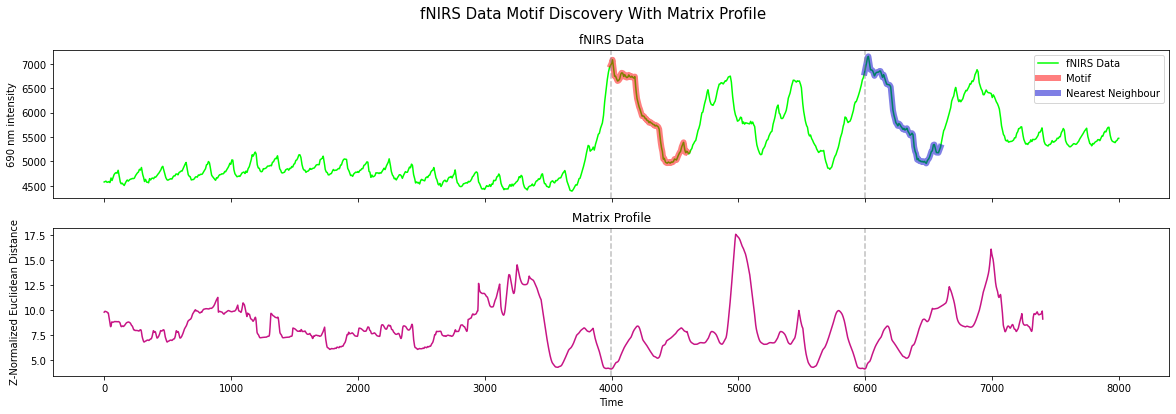

In [9]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('fNIRS Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(fNIRS_data, color='lime', label='fNIRS Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('690 nm intensity')
axis[0].set_title('fNIRS Data')

axis[1].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

Without further context, the results look like exactly what we want. The two subsequences identified are, in fact, the closest matches.

Now, in order to provide context for this data, we introduce the sensor acceleration dataset, which includes the acceleration data of the sensor worn by the test subject.

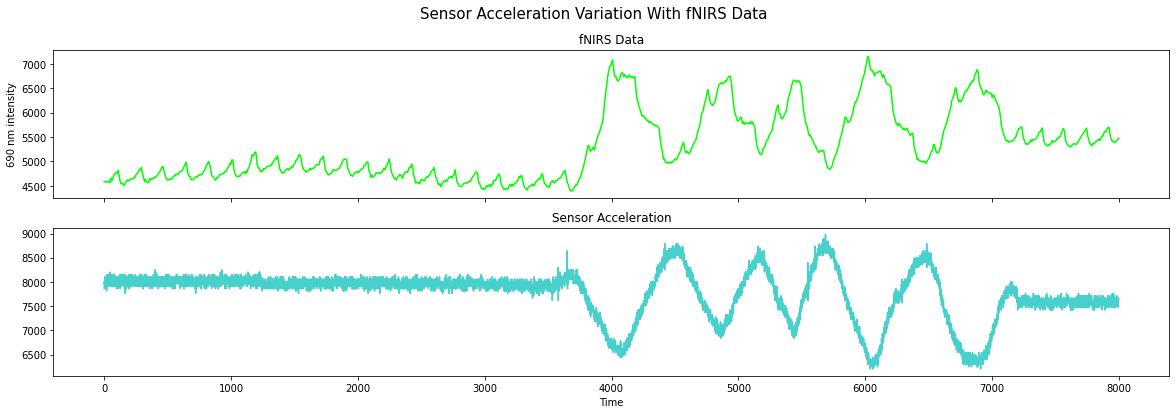

In [10]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Sensor Acceleration Variation With fNIRS Data', fontsize='15')

axis[0].plot(fNIRS_data, color='lime', label='fNIRS Data')
axis[0].set_ylabel('690 nm intensity')
axis[0].set_title('fNIRS Data')

axis[1].plot(acc_data, color='mediumturquoise', label='Sensor Acceleration')
axis[1].set_xlabel('Time')
axis[1].set_title('Sensor Acceleration')

plt.show()

The sensor acceleration data reveals rapid movement between the 4000 and 7000 marks. But what does this mean? Why do we care?

This simply means that the fNIRS data collected during this region has no medical significance. What the brain imaging sensor was picking up during this interval was simply the variation in infrared radiation caused by the physical movement of the test subject and not by the hemoglobin concentrations of the brain.

So, given this data, how do we rule out these intervals? How do we produce an annotation vector from this time series?

We do this by monitoring the variations in the sensor acceleration. We start by computing the sliding standard deviation of the acceleration data. This gives us the standard deviation vector of the subsequences of this time series. We then compute the overall mean of the standard deviation vector and compare the sliding standard deviation to the mean at different parts of the time series.

If at any point in the time series, the local standard deviation is greater than the mean of the standard deviation vector, this indicates a region of physical movement, and so the annotation vector of this region should be 0. Similarly, if the local standard deviation is less than the mean of the standard deviation vector, this indicates a region that's possibly free from physical movement, so we annotate this region to a 1 in the annotation vector.

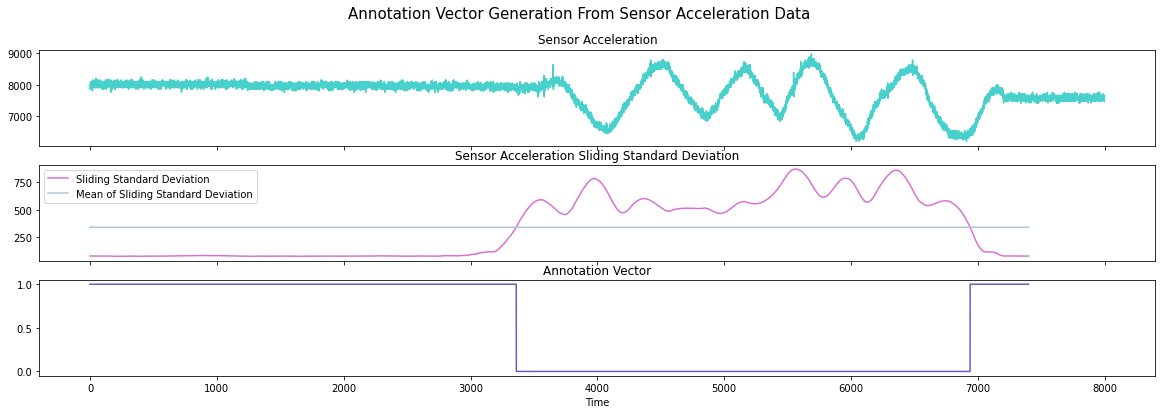

In [11]:
acc_stdev = pd.Series(acc_data).rolling(window_size).std()
acc_stdev = np.array(acc_stdev[window_size - 1:])

acc_stdev_mean = np.mean(acc_stdev)
acc_stdev_mean_series = np.full(np.shape(acc_stdev)[0], acc_stdev_mean)

annotation_vector = (acc_stdev < acc_stdev_mean).astype(np.uint8)

fig, axis = plt.subplots(3, sharex=True)
plt.suptitle('Annotation Vector Generation From Sensor Acceleration Data', fontsize='15')

axis[0].plot(acc_data, color='mediumturquoise', label='Sensor Acceleration')
axis[0].set_title('Sensor Acceleration')

axis[1].plot(acc_stdev, color='orchid', label='Sliding Standard Deviation')
axis[1].plot(acc_stdev_mean_series, color='lightsteelblue', label='Mean of Sliding Standard Deviation')
axis[1].legend()
axis[1].set_title('Sensor Acceleration Sliding Standard Deviation')

axis[2].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[2].set_xlabel('Time')
axis[2].set_title('Annotation Vector')

plt.show()

Now we have an annotation vector that we can use to rule out the regions of physical movement. We can use the formula introduced earlier to compute the corrected matrix profile.

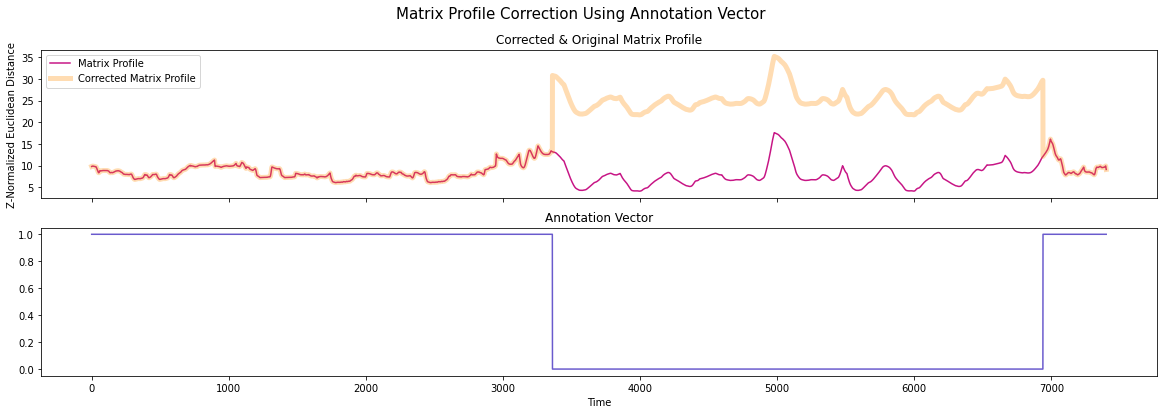

In [12]:
corrected_matrix_profile = matrix_profile[:, 0] + ((1 - annotation_vector) * np.amax(matrix_profile[:, 0]))
corrected_matrix_profile = np.column_stack((corrected_matrix_profile, matrix_profile[:, [1, 2, 3]]))
motif1, motif2 = getMotifData(fNIRS_data, corrected_matrix_profile, window_size)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

As we can see, the corrected matrix profile is elevated around the region of physical movement. This is done to penalize this region. The lowest point in the matrix profile is no longer in the interval where the test subject physically moves. We can now use the corrected matrix profile to locate the nearest neighbor motifs.

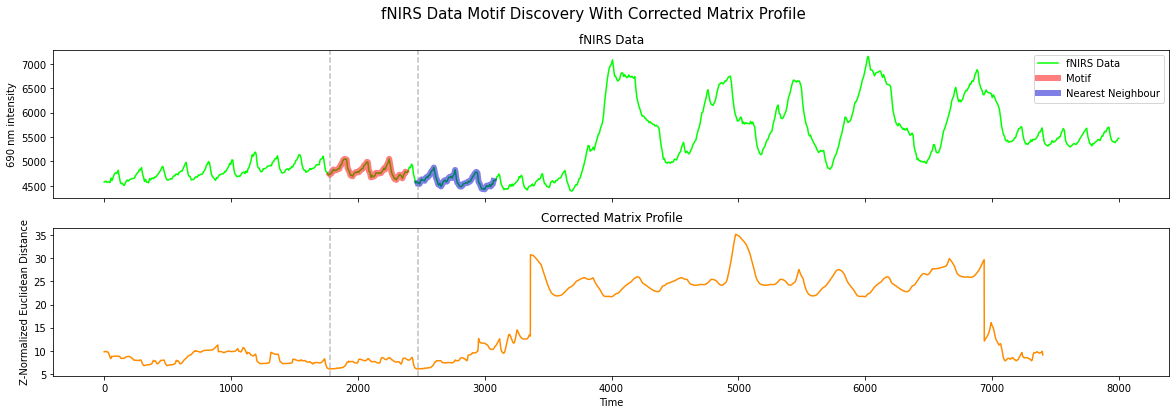

In [13]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('fNIRS Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(fNIRS_data, color='lime', label='fNIRS Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('690 nm intensity')
axis[0].set_title('fNIRS Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='darkorange', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

As we can see, the nearest neighbor pairs have moved towards the left near the smaller peaks that correspond to more desirable data.

### Suppressing Hard-Limited Artifacts

Consider the [EOG dataset](https://drive.google.com/file/d/0B1ZwONZKxJgTVlJNOHExZVdQakU/view?usp=sharing&resourcekey=0--td4bLttW9gLas65IU1leg) containing EOG data of the left-eye, sampled at 50 Hz. **EOG**, or **Electrooculography**, is a technique for measring the potential that exists between the front and back of the human eye. We can download and visualize the data to better understand its trend.

In [14]:
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTVlJNOHExZVdQakU

Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTVlJNOHExZVdQakU
To: C:\Users\zzaman\Documents\personal\STUMPY\AnnotationVectors\EOGL_short_subLen_450.mat

  0%|          | 0.00/8.69k [00:00<?, ?B/s]
100%|##########| 8.69k/8.69k [00:00<00:00, 65.9kB/s]
100%|##########| 8.69k/8.69k [00:00<00:00, 65.9kB/s]


In [15]:
dataset = loadmat('EOGL_short_subLen_450.mat')
EOG_data = dataset['data'][:, 0]

df = {
    'EOG Data': EOG_data,
}

df = pd.DataFrame(df)
df.head()

,EOG Data
0,-0.980
1,2.941
2,2.941
3,2.941
4,2.941


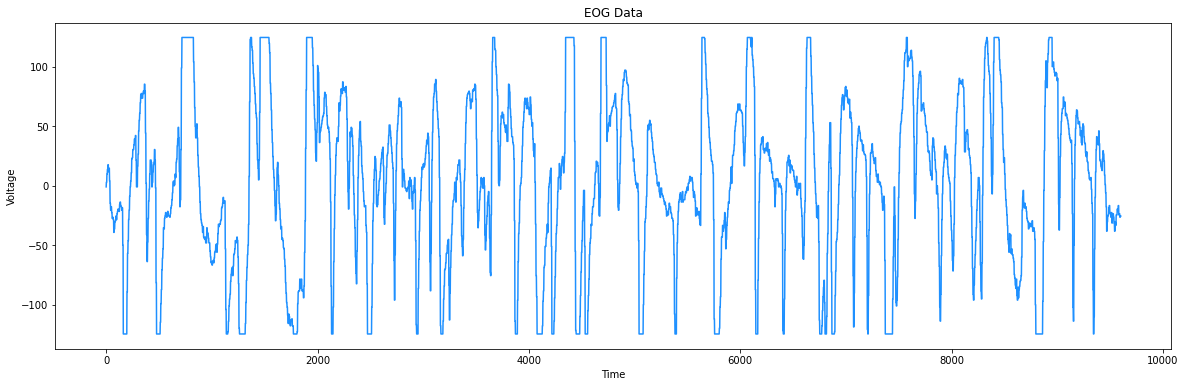

In [16]:
EOG_data = EOG_data.astype(np.float64)

plt.plot(EOG_data, color='dodgerblue', label='EOG Data')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('EOG Data')

plt.show()

You should notice that some points in the plot have flat tops or bottoms. Medically, this is not reflecting reality. The flat tops and bottoms are simply oveflow or underflow points respectively, since the variable used to store the data had the storage capacity of a signed 8-bit floating point number. We can locate these regions for visualization.

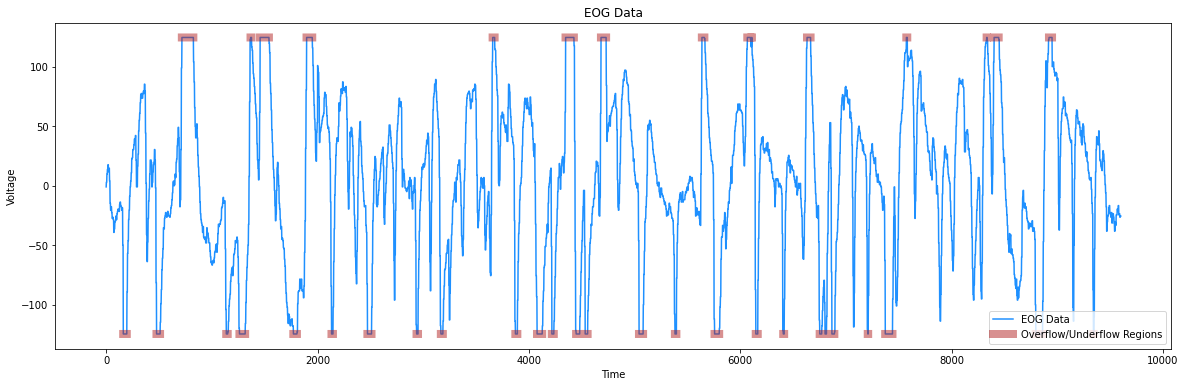

In [17]:
overflow_val = np.amax(EOG_data)
underflow_val = np.amin(EOG_data)

flat_values = np.zeros(len(EOG_data))
for i in range(len(EOG_data)):
    if EOG_data[i] == overflow_val or EOG_data[i] == underflow_val:
        flat_values[i] = EOG_data[i]
    else:
        flat_values[i] = np.nan

plt.plot(EOG_data, color='dodgerblue', label='EOG Data')
plt.plot(flat_values, color='firebrick', alpha=0.5, linewidth=8, label='Overflow/Underflow Regions')
plt.legend(loc ='lower right')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('EOG Data')

plt.show()

We can compute the matrix profile and locate the best motifs.

In [18]:
window_size = 450
matrix_profile = stump(EOG_data, window_size)
motif1, motif2 = getMotifData(EOG_data, matrix_profile, window_size)

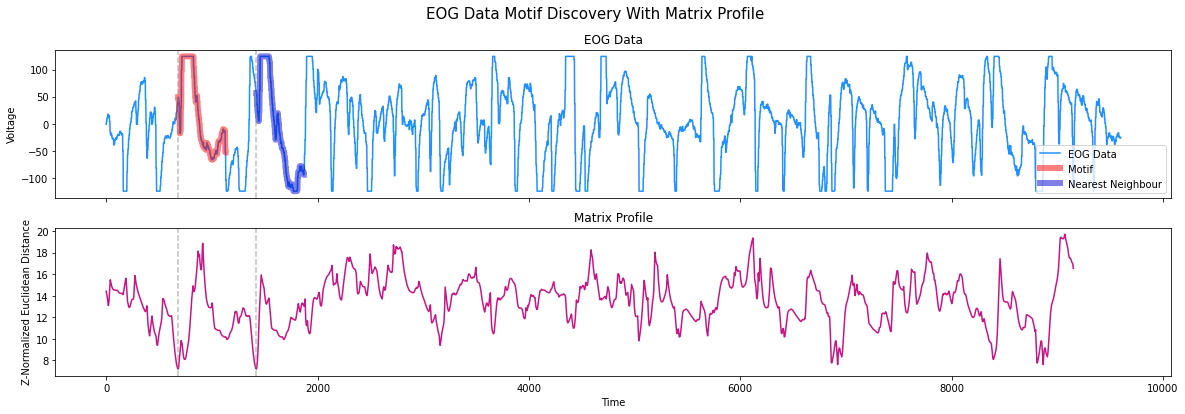

In [19]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('EOG Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(EOG_data, color='dodgerblue', label='EOG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('Voltage')
axis[0].set_title('EOG Data')

axis[1].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

Unsurprisingly, the nearest neighbors contain the biggest flat top of the time series. This makes sense, since the z-normalized Euclidean distance between two flat tops is very low.

Of course, because the flat tops or bottoms are areas where the actual value of the EOG is unclear, we want to make this a less desirable motif. But the difference between the previous case with the fNIRS data and this is that, with the EOG data we don't want to completely dismiss areas of overflow or underflow. Rather, we want to slightly penalize them.

We do this by constructing an annotation vector that is real-valued, as opposed to the previous example where it could only be 0 or 1. For every subsequence, we count the number of values that are equal to the global minimum or maximum. The more that number is, the lower we set the annotation vector value for that subsequence, and vice versa.

In [20]:
annotation_vector = np.zeros(len(EOG_data) - window_size + 1)

for i in range(len(EOG_data) - window_size + 1):
    window = EOG_data[i:i + window_size]
    annotation_vector[i] = np.count_nonzero(window == overflow_val) + np.count_nonzero(window == underflow_val)
    
annotation_vector = annotation_vector - np.amin(annotation_vector)
annotation_vector = annotation_vector / np.amax(annotation_vector)
annotation_vector = 1 - annotation_vector

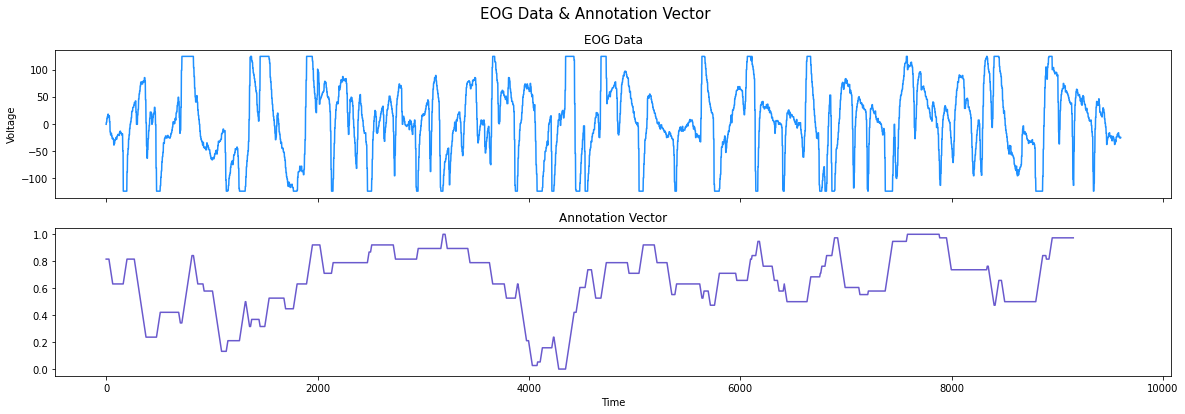

In [21]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('EOG Data & Annotation Vector', fontsize='15')

axis[0].plot(EOG_data, color='dodgerblue', label='EOG Data')
axis[0].set_ylabel('Voltage')
axis[0].set_title('EOG Data')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

Now we have an annotation vector that is lower at subsequences that contain flat tops or bottoms, and higher where there are no flat tops or bottoms. We use this to generate the corrected matrix profile.

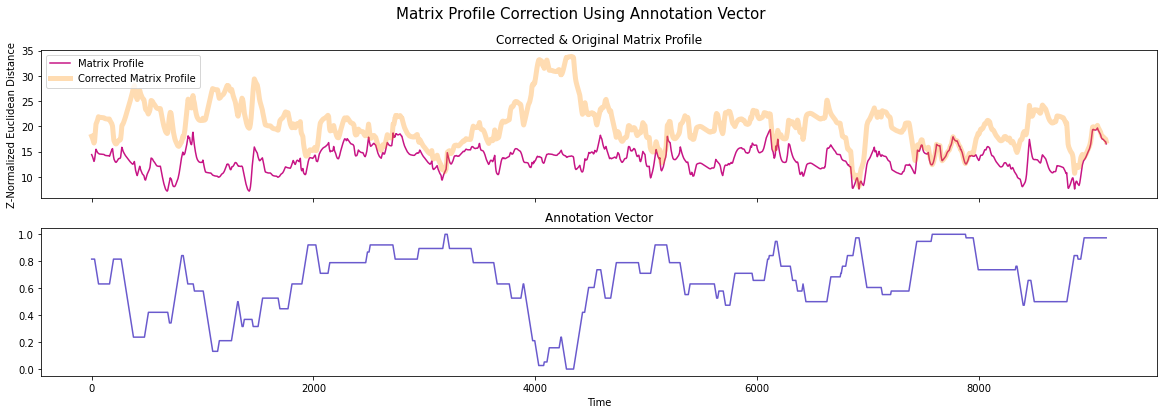

In [22]:
corrected_matrix_profile = matrix_profile[:, 0] + ((1 - annotation_vector) * np.amax(matrix_profile[:, 0]))
corrected_matrix_profile = np.column_stack((corrected_matrix_profile, matrix_profile[:, [1, 2, 3]]))
motif1, motif2 = getMotifData(EOG_data, corrected_matrix_profile, window_size)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

Clearly, the subsequences with the lowest distance value has changed. Now we compute the motifs again.

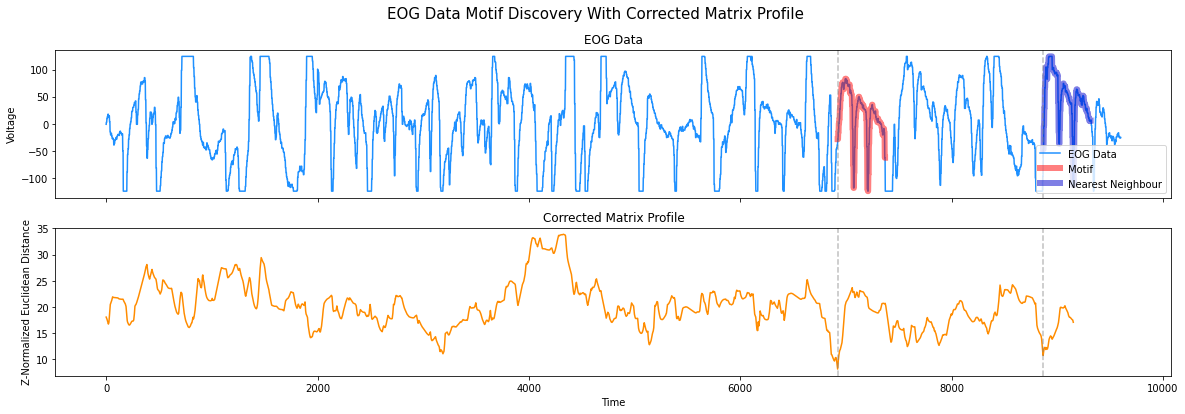

In [23]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('EOG Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(EOG_data, color='dodgerblue', label='EOG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_ylabel('Voltage')
axis[0].set_title('EOG Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='darkorange', label='Corrected Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

As we can see, the new motifs are no longer at flat top or bottom regions. Once again, we've redirected the algorithm to find more interesting motifs.

## Stop-Word Motif Bias

As mentioned earlier, when analyzing the Amazon customer reviews dataset, we would probably want to remove all stop-words before our analysis. We would often like to do something similar in time series motif search. In many time series datasets, there may be visible "stop-word" subsequences, that are expected but contribute to nothing insightful. For the Amazon customer reviews dataset, words like "Amazon", "order", "shipping", "the", "and" would be such examples.

Consider the [ECG data snippet](https://drive.google.com/file/d/0B1ZwONZKxJgTTVJON3Q0aXpZSGc/view?usp=sharing&resourcekey=0-q5yEeGF3D5O7F6Ap8MfqqQ) from the [LTAF-71 dataset](https://physionet.org/content/ltafdb/1.0.0/). **ECG**, or **Electrocardiography** is the measurement of electrical activity of the heart. We start by downloading and visualizing the time series data.

In [24]:
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTTVJON3Q0aXpZSGc

Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTTVJON3Q0aXpZSGc
To: C:\Users\zzaman\Documents\personal\STUMPY\AnnotationVectors\ECG_LTAF_71_subLen_150.mat

  0%|          | 0.00/3.65k [00:00<?, ?B/s]
100%|##########| 3.65k/3.65k [00:00<00:00, 22.3kB/s]
100%|##########| 3.65k/3.65k [00:00<00:00, 22.3kB/s]


In [25]:
dataset = loadmat('ECG_LTAF_71_subLen_150.mat')
ECG_data = dataset['data'][0]

df = {
    'ECG Data': ECG_data,
}

df = pd.DataFrame(df)
df.head()

,ECG Data
0,79
1,84
2,81
3,83
4,81


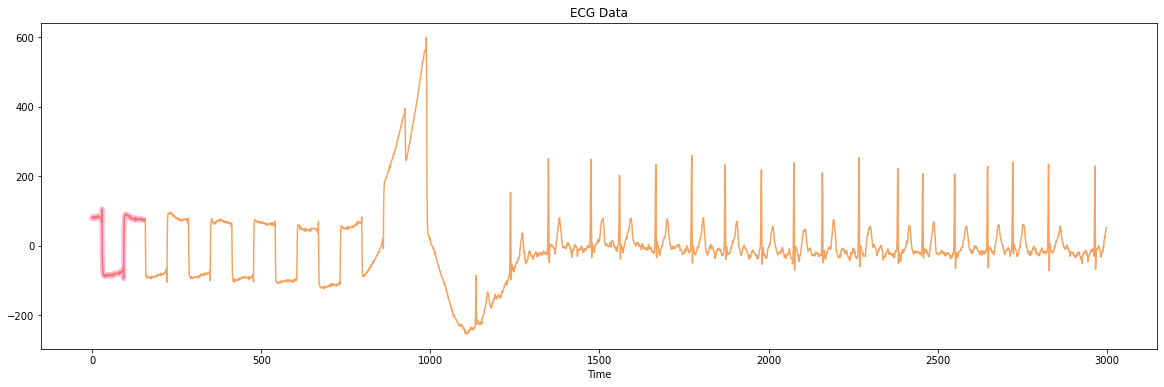

In [26]:
ECG_data = ECG_data.astype(np.float64)
window_size = 150
stopword = ECG_data[:window_size]

plt.plot(ECG_data, color='sandybrown', label='ECG Data')
plt.plot(np.array(range(0, window_size)), stopword, color='deeppink', alpha=0.3, linewidth=5)
plt.xlabel('Time')
plt.title('ECG Data')

plt.show()

The first parts of the time series include several nearly identical square wave signals. These are caliberation signals that are sent by the ECG apparatus to indicate that it is switched on. These square waves are not coming from the test subject's heart activity, and, needless to say, these are our "stop-words".

We can compute the matrix profile and locate the nearest neighbors.

In [27]:
matrix_profile = stump(ECG_data, window_size)
motif1, motif2 = getMotifData(ECG_data, matrix_profile, window_size)

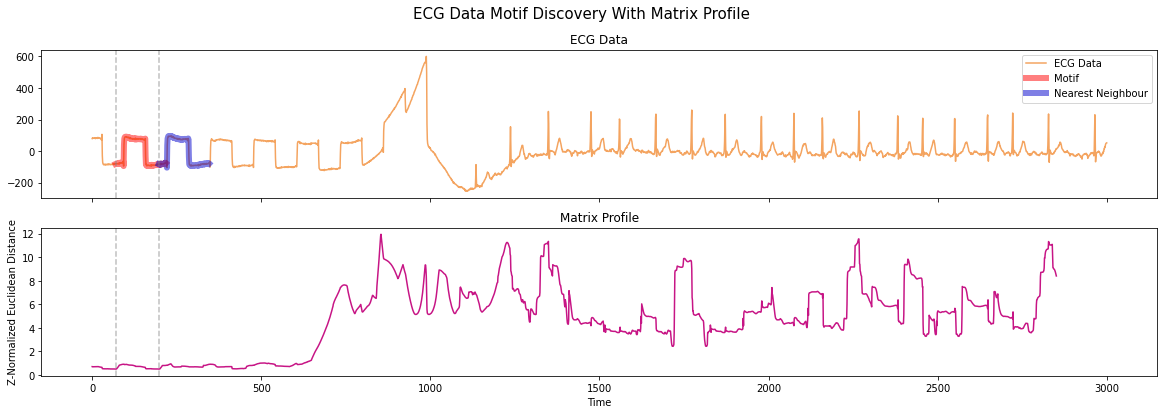

In [28]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('ECG Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(ECG_data, color='sandybrown', label='ECG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('ECG Data')

axis[1].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

As expected, the motif search only returned subsequences in the caliberation region. How do we prevent this? Our objective is to remove anything that looks like the square-wave caliberation signal. In order to do that, we must identify something that "looks" like that square wave.

To solve this issue, we compute the distance profile of the time series with a smaller square-wave subsequence. We can accomplish this using the `mass` function from STUMPY.

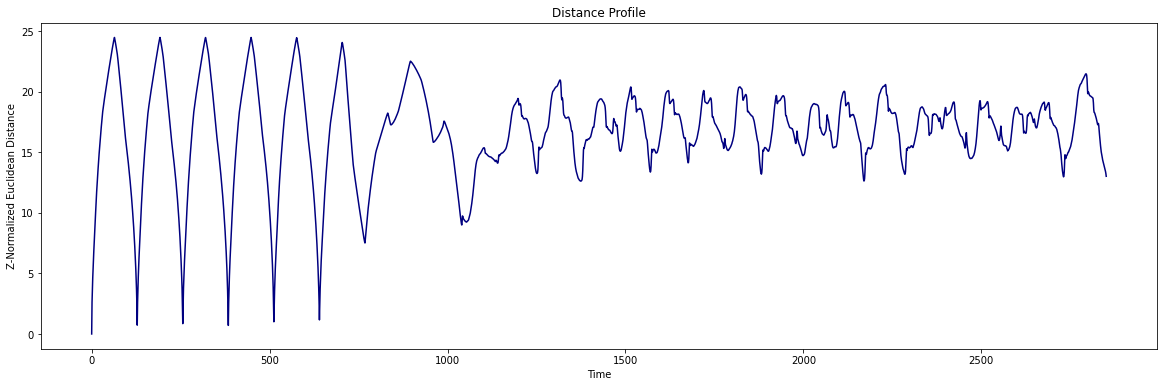

In [29]:
distance_profile = mass(stopword, ECG_data)

plt.plot(distance_profile, color='navy', label='Distance Profile')
plt.xlabel('Time')
plt.ylabel('Z-Normalized Euclidean Distance')
plt.title('Distance Profile')

plt.show()

The distance profile contains bottom peaks near the square-wave caliberation signals. This gives us a way to identify the square-wave signals. We can set a threshold in z-normalized Euclidean distance, below which will be regarded as a caliberation signal. Then, for any caliberation signal, we can set a certain area "near" that signal to be 0 in the annotation vector. Our definition of "near" will be 3m before and after the square-wave signal, where m is the window size, but this definition may vary depending on the dataset and its context.

In [30]:
threshold = 5
annotation_vector = np.ones(len(ECG_data) - window_size + 1)

for i in range(len(ECG_data) - window_size + 1):
    if annotation_vector[i] == 0:
        continue
        
    if distance_profile[i] < threshold:
        exclusion_zone_lower_limit = max(0, i - (3 * window_size))
        exclusion_zone_upper_limit = min(len(ECG_data) - window_size + 1, i + (3 * window_size))
        annotation_vector[exclusion_zone_lower_limit:exclusion_zone_upper_limit] = 0

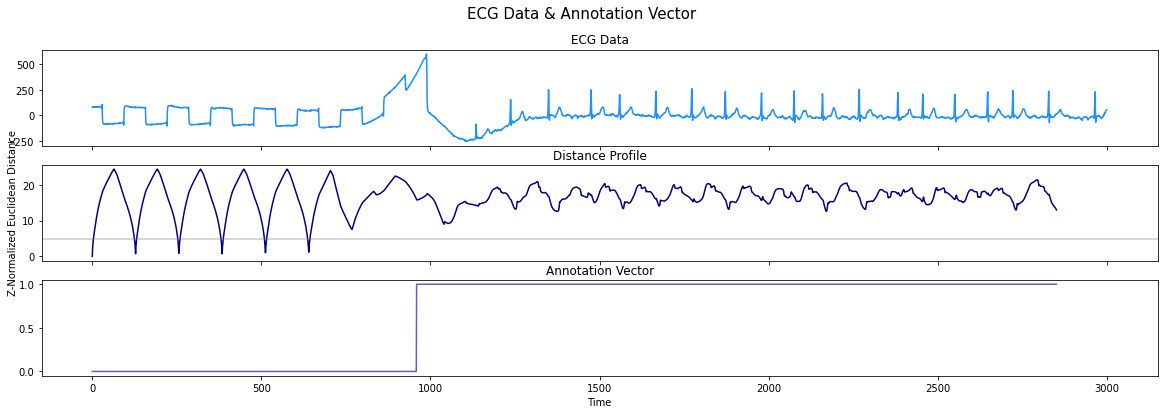

In [31]:
fig, axis = plt.subplots(3, sharex=True)
plt.suptitle('ECG Data & Annotation Vector', fontsize='15')

axis[0].plot(ECG_data, color='dodgerblue', label='ECG Data')
axis[0].set_title('ECG Data')

axis[1].plot(distance_profile, color='navy', label='Distance Profile')
axis[1].axhline(y=threshold, color='slategrey', alpha=0.3, linewidth=2)
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Distance Profile')

axis[2].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[2].set_xlabel('Time')
axis[2].set_title('Annotation Vector')

plt.show()

As we can see, we have produced an annotation vector that is 0 around the caliberation region and 1 otherwise. We use to compute the corrected matrix profile.

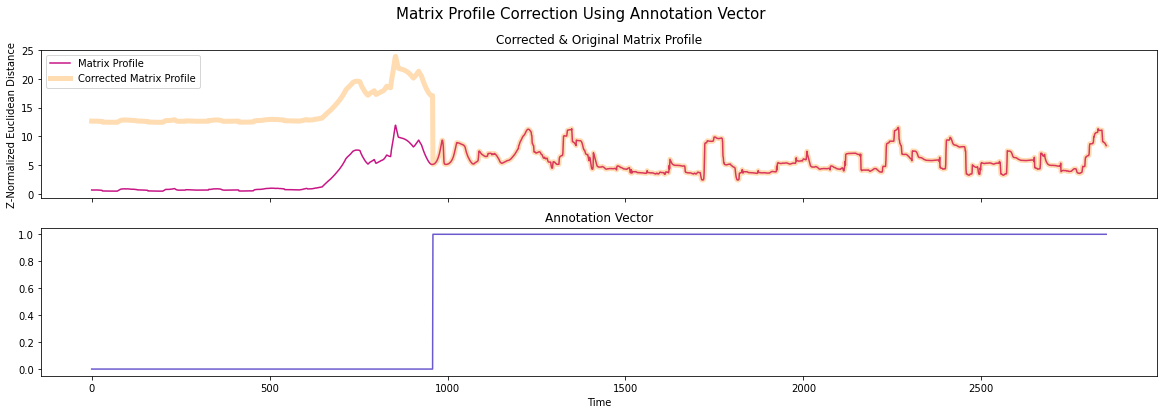

In [32]:
corrected_matrix_profile = matrix_profile[:, 0] + ((1 - annotation_vector) * np.amax(matrix_profile[:, 0]))
corrected_matrix_profile = np.column_stack((corrected_matrix_profile, matrix_profile[:, [1, 2, 3]]))
motif1, motif2 = getMotifData(ECG_data, corrected_matrix_profile, window_size)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

Now we repeat the motif search with the corrected matrix profile.

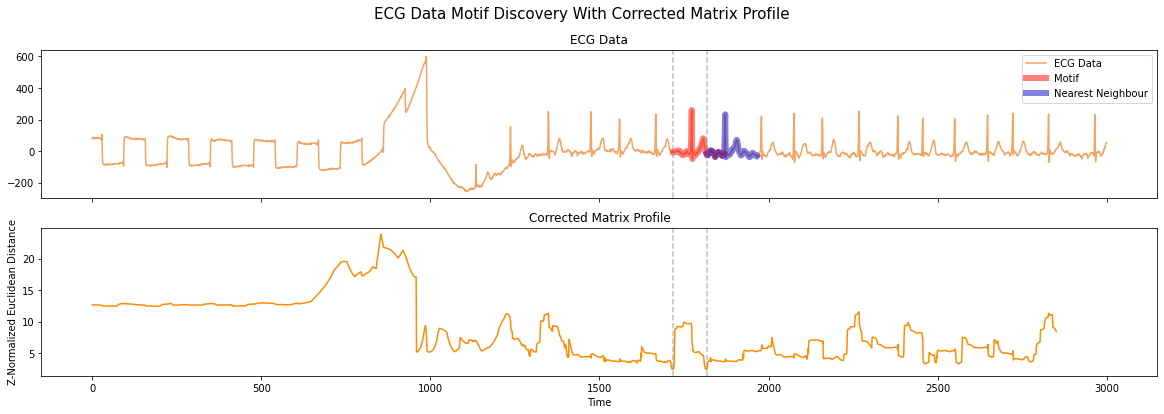

In [33]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('ECG Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(ECG_data, color='sandybrown', label='ECG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('ECG Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='darkorange', label='Corrected Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

Once again, the motifs have moved away from the undesirable region, onto a more desirable region.

## Simplicity Bias

Simplicity Bias is the tendency of the motif search process to pick out regions where there isn't much activity. Sometimes our time series may include mostly regions of inactivity, with a few chunks of useful data. In such cases, we want to penalize motifs around areas that are "simple".

Consider the [Finger Flexion Dataset](https://drive.google.com/file/d/0B1ZwONZKxJgTZlVYRHRRN2E5aU0/view?usp=sharing&resourcekey=0-uJHqC_VGgfi59qB8zhP7Fw). We start by downloading and visualizing this dataset.

In [34]:
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTZlVYRHRRN2E5aU0

Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTZlVYRHRRN2E5aU0
To: C:\Users\zzaman\Documents\personal\STUMPY\AnnotationVectors\finger_flexion_subLen_3500.mat

  0%|          | 0.00/11.3k [00:00<?, ?B/s]
100%|##########| 11.3k/11.3k [00:00<00:00, 54.1kB/s]
100%|##########| 11.3k/11.3k [00:00<00:00, 54.1kB/s]


In [35]:
dataset = loadmat('finger_flexion_subLen_3500.mat')
finger_flexion_data = dataset['data'][:, 0]

df = {
    'Finger Flexion Data': finger_flexion_data,
}

df = pd.DataFrame(df)
df.head()

,Finger Flexion Data
0,-0.418429
1,-0.410371
2,-0.410371
3,-0.410371
4,-0.410371


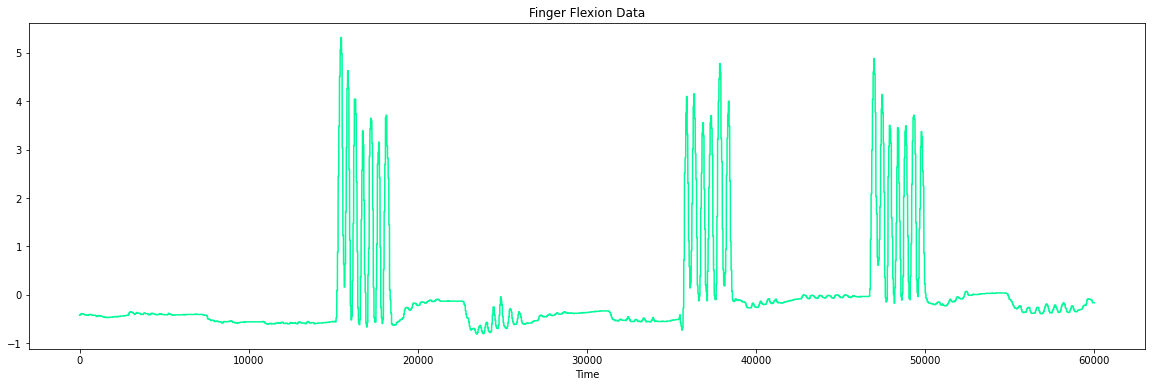

In [36]:
finger_flexion_data = finger_flexion_data.astype(np.float64)

plt.plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
plt.xlabel('Time')
plt.title('Finger Flexion Data')

plt.show()

As we can see, this majority of this time series is not very active, with a few regions of spikes. It's almost completely obvious that a motif search will result in the "simple" areas. We can confirm that by computing the matrix profile and locating the motifs.

In [37]:
window_size = 3500
matrix_profile = stump(finger_flexion_data, window_size)
motif1, motif2 = getMotifData(finger_flexion_data, matrix_profile, window_size)

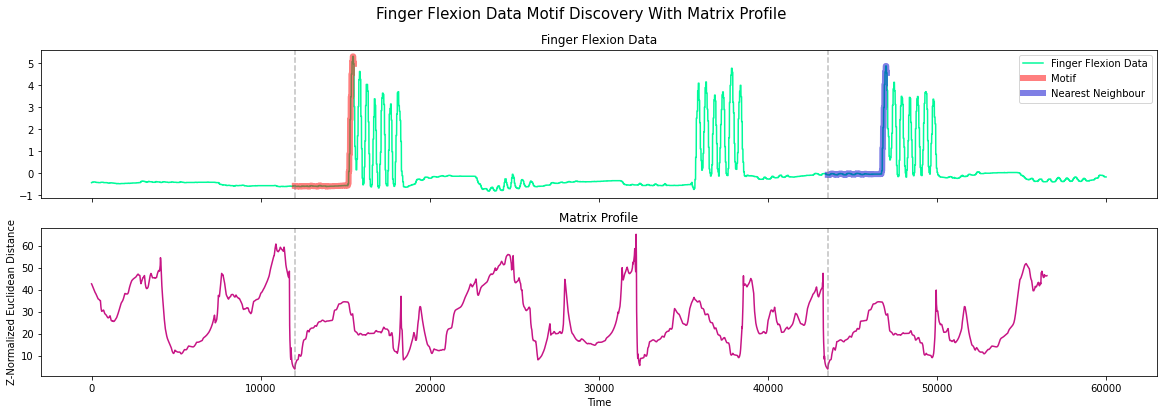

In [38]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Finger Flexion Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('Finger Flexion Data')

axis[1].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

As we expected, most of the nearest neighbor subsequences consist of a flat, simple region. In order to favor regions of more activity, we must penalize regions that are "simple" and reward regions that are "complex". In order to do that, we need to define "complexity".

There are many ways to define a complex time series subsequence. For the purposes of this tutorial, we can use the complexity estimate formula specified in [A Complexity-Invariant Distance Measure for Time Series](https://link.springer.com/article/10.1007/s10618-013-0312-3) paper:

$$
\begin{align*}
CE(Q) &= \sqrt{\sum\limits^{n - 1}_{i = 1}(q_i - q_{i + 1})^2}
\end{align*}
$$

We can use this definition of a complexity vector to construct an annotation vector that will reward motifs in complex regions.

In [39]:
complexity_vector = np.zeros(len(finger_flexion_data) - window_size + 1)

for i in range(len(finger_flexion_data) - window_size + 1):
    CE = np.diff(finger_flexion_data[i:i + window_size])
    CE = np.power(CE, 2)
    CE = np.sum(CE)
    CE = np.sqrt(CE)
    complexity_vector[i] = CE

annotation_vector = complexity_vector
annotation_vector = annotation_vector - np.amin(annotation_vector)
annotation_vector = annotation_vector / np.amax(annotation_vector)

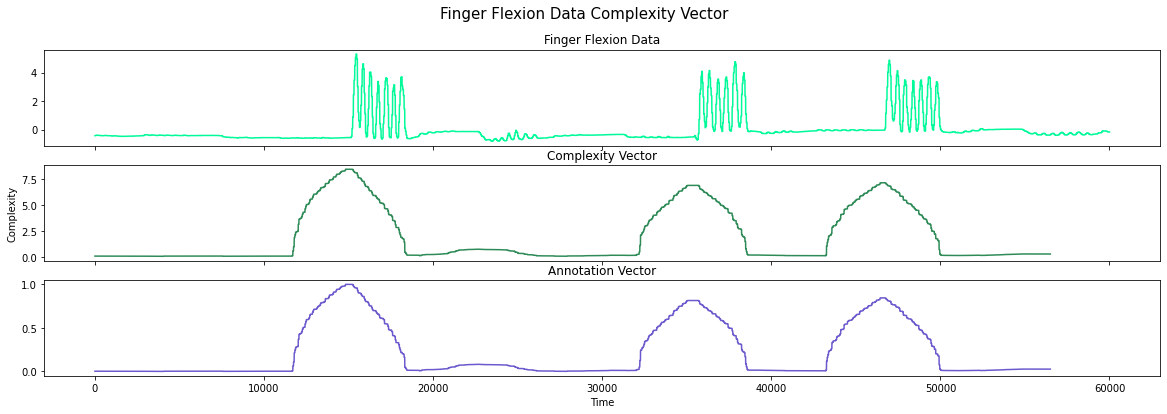

In [40]:
fig, axis = plt.subplots(3, sharex=True)
plt.suptitle('Finger Flexion Data Complexity Vector', fontsize='15')

axis[0].plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
axis[0].set_title('Finger Flexion Data')

axis[1].plot(complexity_vector, color='seagreen', label='Matrix Profile')
axis[1].set_ylabel('Complexity')
axis[1].set_title('Complexity Vector')

axis[2].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[2].set_xlabel('Time')
axis[2].set_title('Annotation Vector')

plt.show()

As we can see, the generated annotation vector is higher around regions that are complex, and lower around regions that are simple. We use this to obtain the corrected matrix profile.

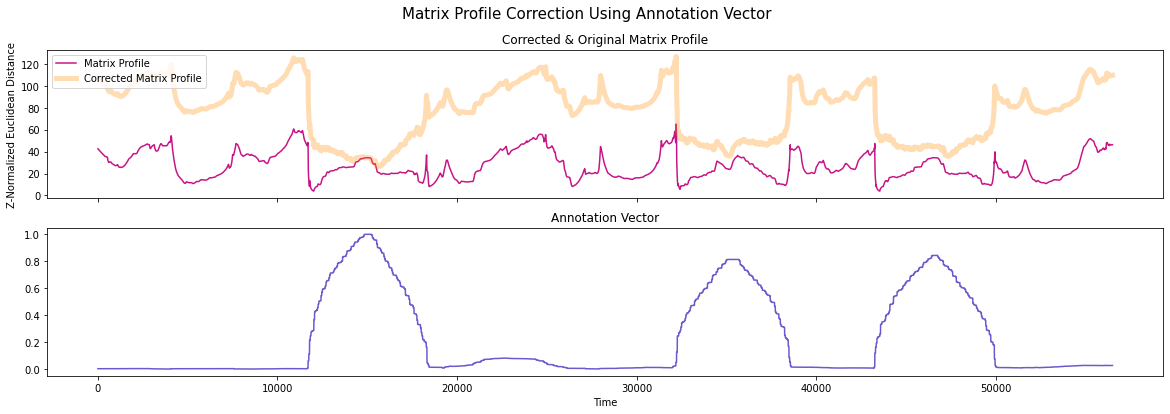

In [41]:
corrected_matrix_profile = matrix_profile[:, 0] + ((1 - annotation_vector) * np.amax(matrix_profile[:, 0]))
corrected_matrix_profile = np.column_stack((corrected_matrix_profile, matrix_profile[:, [1, 2, 3]]))
motif1, motif2 = getMotifData(finger_flexion_data, corrected_matrix_profile, window_size)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

This provides us with a corrected matrix profile that penalizes simplicity. We use this to search for motifs.

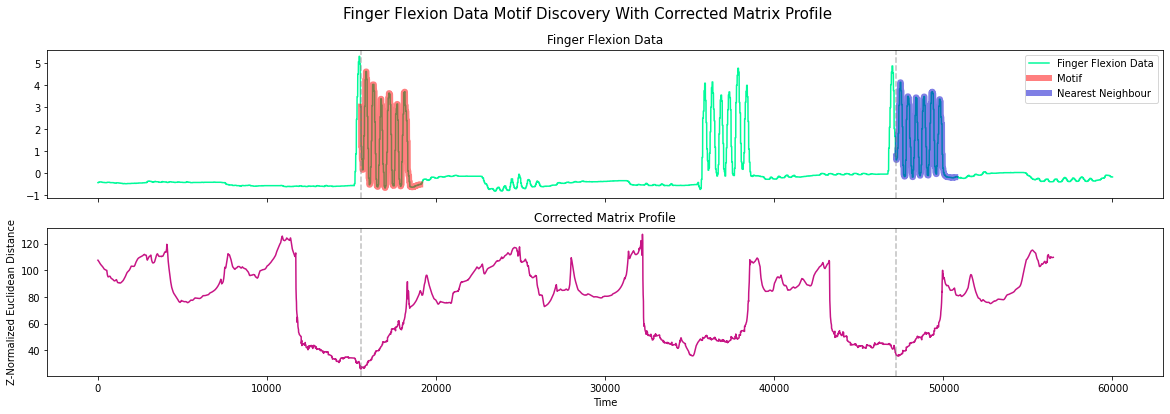

In [42]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Finger Flexion Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('Finger Flexion Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

The nearest neighbor subsequences are now near regions of more activity.